In [2]:
!pip install pandas_datareader

In [28]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

<AxesSubplot:xlabel='Date'>

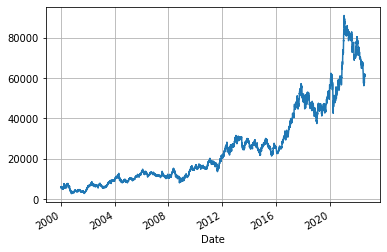

In [29]:
start = (2000, 1, 1)  # 2020년 01년 01월 
start = datetime.datetime(*start)  
end = datetime.date.today()  # 현재 

# yahoo 에서 삼성 전자 불러오기 
df = pdr.DataReader('005930.KS', 'yahoo', start, end)
#df.head(5)
#df.tail(5)
df.Close.plot(grid=True)

In [30]:
'''
open 시가
high 고가
low 저가
close 종가
volume 거래량
Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가
'''
df.head()
X = df.drop(columns='Volume')
y = df.iloc[:, 5:6]

print(X)
print(y)

               High      Low     Open    Close     Adj Close
Date                                                        
2000-01-04   6110.0   5660.0   6000.0   6110.0   4623.467773
2000-01-05   6060.0   5520.0   5800.0   5580.0   4222.415527
2000-01-06   5780.0   5580.0   5750.0   5620.0   4252.680664
2000-01-07   5670.0   5360.0   5560.0   5540.0   4192.145508
2000-01-10   5770.0   5580.0   5600.0   5770.0   4366.187988
...             ...      ...      ...      ...           ...
2022-08-01  61700.0  60300.0  61000.0  61300.0  61300.000000
2022-08-02  61900.0  61000.0  61200.0  61700.0  61700.000000
2022-08-03  61600.0  61000.0  61600.0  61300.0  61300.000000
2022-08-04  61800.0  61200.0  61700.0  61500.0  61500.000000
2022-08-05  61900.0  61200.0  61700.0  61500.0  61500.000000

[5673 rows x 5 columns]
               Adj Close
Date                    
2000-01-04   4623.467773
2000-01-05   4222.415527
2000-01-06   4252.680664
2000-01-07   4192.145508
2000-01-10   4366.187988
...    

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

# Test Data 
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (4500, 5) (4500, 1)
Testing Shape (1173, 5) (1173, 1)


In [32]:
# torch variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1173, 1, 5]) torch.Size([1173, 1])


In [34]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [35]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [36]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to()

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [37]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to()) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to())

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.00974
Epoch: 100, loss: 0.00933
Epoch: 200, loss: 0.00903
Epoch: 300, loss: 0.00872
Epoch: 400, loss: 0.00842
Epoch: 500, loss: 0.00811
Epoch: 600, loss: 0.00781
Epoch: 700, loss: 0.00751
Epoch: 800, loss: 0.00721
Epoch: 900, loss: 0.00691
Epoch: 1000, loss: 0.00661
Epoch: 1100, loss: 0.00632
Epoch: 1200, loss: 0.00604
Epoch: 1300, loss: 0.00575
Epoch: 1400, loss: 0.00547
Epoch: 1500, loss: 0.00520
Epoch: 1600, loss: 0.00493
Epoch: 1700, loss: 0.00467
Epoch: 1800, loss: 0.00441
Epoch: 1900, loss: 0.00416
Epoch: 2000, loss: 0.00391
Epoch: 2100, loss: 0.00367
Epoch: 2200, loss: 0.00344
Epoch: 2300, loss: 0.00321
Epoch: 2400, loss: 0.00299
Epoch: 2500, loss: 0.00278
Epoch: 2600, loss: 0.00258
Epoch: 2700, loss: 0.00238
Epoch: 2800, loss: 0.00219
Epoch: 2900, loss: 0.00202
Epoch: 3000, loss: 0.00185
Epoch: 3100, loss: 0.00169
Epoch: 3200, loss: 0.00154
Epoch: 3300, loss: 0.00140
Epoch: 3400, loss: 0.00126
Epoch: 3500, loss: 0.00114
Epoch: 3600, loss: 0.00103
Epoch: 3700, 

In [38]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

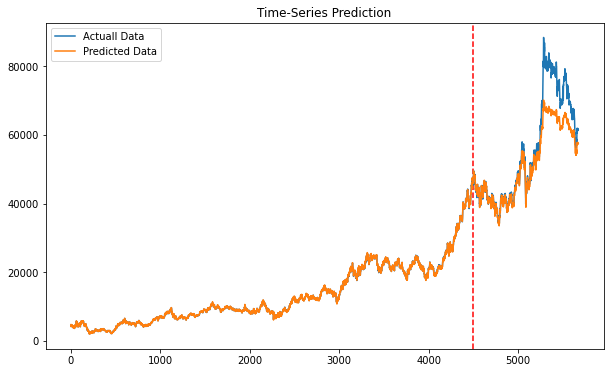

In [39]:
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 